In [ ]:
import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df0 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/accel_data/clap_2025-09-03-17-11-07_xyz_data.csv")
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/accel_data/rotate_2025-09-03-16-51-53_xyz_data.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/accel_data/shake_2025-09-03-13-29-49_xyz_data.csv")


df0["label"] = 0
df1["label"] = 1
df2["label"] = 2


# データの先頭を表示
print(df0.head())
print(df1.head())
print(df2.head())

             Timestamp   No      x     y      z  label
0  2025-09-03 17:09:06  104 -10424  -836  14428      0
1  2025-09-03 17:09:06  105  -7984 -2364  15352      0
2  2025-09-03 17:09:06  106 -13148 -4572   8656      0
3  2025-09-03 17:09:06  107 -17112 -3172    416      0
4  2025-09-03 17:09:06  108 -14332  -932   6832      0
             Timestamp  No      x     y      z  label
0  2025-09-03 16:49:52  92  -8456  2732  13992      1
1  2025-09-03 16:49:52  93  -8492  4916  14180      1
2  2025-09-03 16:49:52  94  -8864  4040  13680      1
3  2025-09-03 16:49:52  95 -10768  1488  12104      1
4  2025-09-03 16:49:53  96  -9596  4932  12872      1
             Timestamp   No      x     y      z  label
0  2025-09-03 13:27:48  112  12928 -1156   9952      2
1  2025-09-03 13:27:48  113  13524  -732  10984      2
2  2025-09-03 13:27:48  114  14808  -284   9832      2
3  2025-09-03 13:27:48  115  13156 -2620  11776      2
4  2025-09-03 13:27:48  116  11520 -3552  10048      2


In [ ]:
df_all = pd.concat([df0, df1, df2], ignore_index=True)

scaler = StandardScaler()
scaled_xyz = scaler.fit_transform(df_all[["x", "y", "z"]])

In [ ]:
def create_windows(data, labels, window_size, step_size):
    X, y = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        if len(set(labels[i:i+window_size])) != 1:
            continue
        window = data[i:i+window_size]
        label = labels[i] #labels[i + window_size // 2]  # 中央のラベルを代表とする
        X.append(window)
        y.append(label)
    return np.array(X), np.array(y)

window_size = 6  # 0.5秒 × 12Hz
step_size = 1    # 75%オーバーラップ

X, y = create_windows(scaled_xyz, df_all["label"].values, window_size, step_size)
X_reshaped = X.reshape(-1, 18)  # モデルに渡す前にFlattenしておく

In [ ]:
# データ分割（80%訓練, 20%テスト）
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# ラベルをワンホットエンコード
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [ ]:
# --- モデル構築 ---
model = Sequential([
    Dense(128, activation='relu', input_shape=(18,)),  # 6×3 = 18次元ベクトル
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 学習
model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_split=0.2)

# モデルの保存
#model.save("my_model.h5")

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4751 - loss: 1.0716 - val_accuracy: 0.8709 - val_loss: 0.4856
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7693 - loss: 0.5833 - val_accuracy: 0.9040 - val_loss: 0.3065
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8140 - loss: 0.4526 - val_accuracy: 0.9267 - val_loss: 0.2212
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8814 - loss: 0.3542 - val_accuracy: 0.9459 - val_loss: 0.1668
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9018 - loss: 0.2776 - val_accuracy: 0.9529 - val_loss: 0.1411
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9123 - loss: 0.2431 - val_accuracy: 0.9599 - val_loss: 0.1143
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9292 - loss: 0.1957 - val_accuracy: 0.9756 - val_loss: 0.0999
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9325 - loss: 0.1878 - val_accuracy: 0.9738 - val_loss: 0.0888
Epo

In [ ]:
# モデル読み込み
#model = load_model("/content/drive/MyDrive/Colab Notebooks/my_model.h5")

# 推論（X_testは shape: [n_samples, 6, 3]）
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0436 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       239
           1       0.98      0.98      0.98       239
           2       0.98      1.00      0.99       239

    accuracy                           0.99       717
   macro avg       0.99      0.99      0.99       717
weighted avg       0.99      0.99      0.99       717



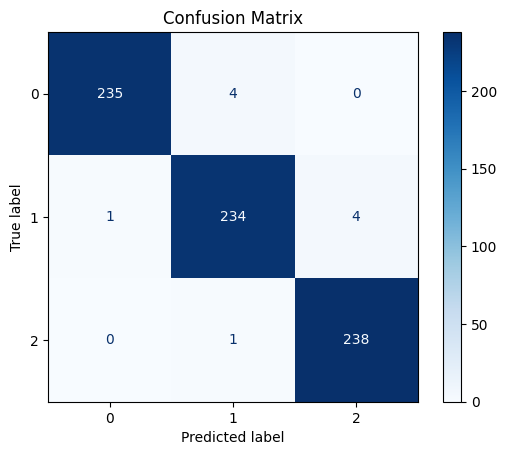

In [ ]:
model.evaluate(X_test, y_test_cat)

# 正解ラベル（ワンホット → 整数ラベルに変換）
y_true = np.argmax(y_test_cat, axis=1)

# 分類レポートの表示
print(classification_report(y_true,y_pred))

# 混同行列の作成と表示
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# TFLite変換器の作成
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#変換の実行
tflite_model = converter.convert()

#ファイルとして保存
with open("/content/drive/MyDrive/Colab Notebooks/model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp29bspdfx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 18), dtype=tf.float32, name='keras_tensor_31')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140087990711696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140088550154768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140087990711312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140087994558288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140087994548304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140087994550608: TensorSpec(shape=(), dtype=tf.resource, name=None)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       239
           1       0.97      0.98      0.97       239
           2       0.98      0.98      0.98       239

    accuracy                           0.98       717
   macro avg       0.98      0.98      0.98       717
weighted avg       0.98      0.98      0.98       717



/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


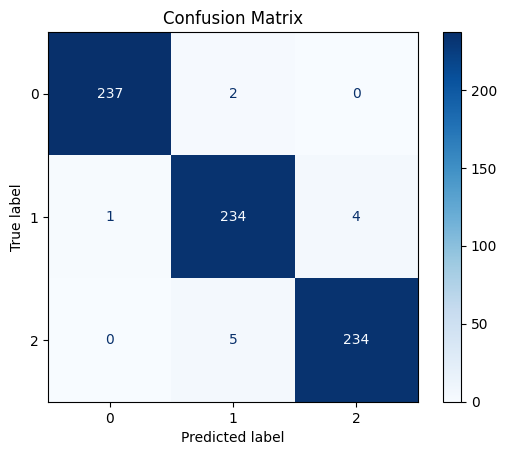

In [ ]:
# TFLiteモデルの読み込み
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Colab Notebooks/model.tflite")
interpreter.allocate_tensors()

# 入出力テンソル情報の取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# x_test_cat の準備（実データに置き換えてください）
window_size = input_details[0]['shape'][1]
num_features = input_details[0]['shape'][2]

# 推論の実行
predictions = []
for sample in  X_test:
    input_data = np.expand_dims(sample, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

# One-hot形式の正解ラベルを整数ラベルに変換
true_labels = np.argmax(y_test_cat, axis=1)
# softmax出力の予測ラベルを整数ラベルに変換  predictions: list of (1, 3) arrays → reshape to (N, 3)
predictions_array = np.squeeze(np.array(predictions), axis=1)
# softmax出力 → クラス番号
predicted_labels = np.argmax(predictions_array, axis=1)


# 分類レポートの表示
print(classification_report(true_labels, predicted_labels))

# 混合行列の表示
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
